In [4]:
import copy
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt


from superprimitive_fusion.scanner import (
    virtual_mesh_scan,
    virtual_scan,
    mesh_depth_image,
    generate_rgbd_noise,
    clean_mesh_and_remap_weights,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    distinct_colours,
)
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)
from superprimitive_fusion.mesh_fusion_utils import (
    get_mesh_components,
)

In [2]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
    ('bleach', 'bleach.obj'),
    ('pitcher', 'pitcher.obj'),
    ('mug', 'mug.obj'),
    # ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

gt_meshes = dict()
for foldername,filename in names:
    print(f'Getting the {foldername}')
    
    gt_mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(gt_mesh)
    gt_mesh.compute_vertex_normals()

    gt_meshes[foldername] = gt_mesh

gt_mesh_list = list(gt_meshes.values())

Getting the mustard-bottle
Getting the table
Getting the power-drill
Getting the bleach
Getting the pitcher
Getting the mug


In [5]:
centres = []
for gt_meshname, gt_mesh in gt_meshes.items():
    if gt_meshname == 'table':
        continue
    centres.append(gt_mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

In [6]:
cam_centre_offset=np.array([0, 0, 0.2])
look_at = obj_centre
width_px: int = 360
height_px: int = 240
fov: float = 70.0
k: float = 3.5
max_normal_angle_deg = None

In [10]:
scans = []
N = 3
for theta in np.linspace(0,360/N * (N-1), N):
# for theta in np.linspace(30,180, N):
    print(theta)
    scan = virtual_scan(
        meshlist=gt_mesh_list,
        cam_centre=cam_centre_offset + polar2cartesian(0.8, 30, theta),
        look_at=look_at,
        width_px=width_px,
        height_px=height_px,
        fov=fov,
        up=[0, 0, 1],
    )
    scans.append(scan)

0.0
120.0
240.0


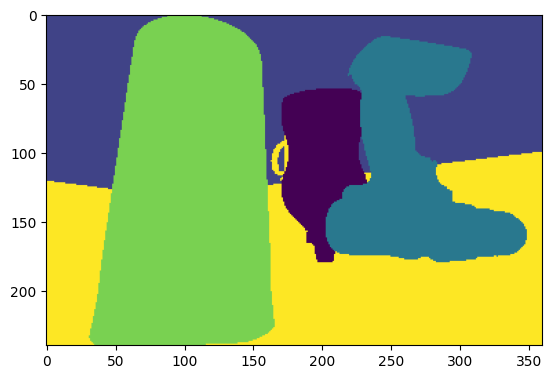

In [13]:
scan = scans[2]
plt.imshow(scan['segmt'])

In [24]:
scans = []
N = 10
for theta in np.linspace(0,360/N * (N-1), N):
# for theta in np.linspace(30,180, N):
    print(theta)
    object_meshes, object_weights = virtual_mesh_scan(
        meshlist=gt_mesh_list,
        cam_centre=cam_centre_offset + polar2cartesian(0.8, 30, theta),
        look_at=look_at,
        k=10,
        max_normal_angle_deg=None,
        linear_depth_sigma=0,
        quadrt_depth_sigma=0,
        sigma_floor=1e-4,
    )
    scans.append([(m,w) for m,w in zip(object_meshes, object_weights)])
    # o3d.visualization.draw_geometries(object_meshes)

0.0
36.0
72.0
108.0
144.0
180.0
216.0
252.0
288.0
324.0


In [ ]:
fused_scan = scans[0]
N = len(scans[0])
assert len(set([len(scan) for scan in scans])) == 1

for t in range(1,len(scans)-1):
    fused_scan_meshes = []
    fused_scan_weights = []
    for obj_id in range(N):
        print(f't={t}, obj_id={obj_id}')
        fused_obj_mesh, fused_obj_weights = fuse_meshes(
            mesh1           = fused_scan[obj_id][0],
            weights1        = fused_scan[obj_id][1],
            mesh2           = scans[t][obj_id][0],
            weights2        = scans[t][obj_id][1],
            h_alpha         = 2.5,
            r_alpha         = 2.0,
            nrm_shift_iters = 2,
            nrm_smth_iters  = 1,
            shift_all       = False,
            fill_holes      = False,
        )
        fused_scan_meshes.append(fused_obj_mesh)
        fused_scan_weights.append(fused_obj_weights)
        
    fused_scan = [(m,w) for m,w in zip(fused_scan_meshes, fused_scan_weights)]

In [27]:
fused_mesh_result = [obj[0] for obj in fused_scan]
o3d.visualization.draw_geometries(fused_mesh_result)